In [84]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_long_from_analysis,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.legend_handler import HandlerTuple
from amftrack.util.plot import gridplot
import logging
from datetime import timedelta

%store -r path_figure

logging.getLogger().setLevel(logging.WARNING)
plt.style.use('presentation.mplstyle')

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

plates_paper = [
    "52_20220707",
    "56_20220701",
    "59_20201126",
    "69_20201119",
    "76_20210108",
    "81_20220704",
    "84_20220621",
    "94_20201123",
    "102_20201226",
    "152_20201224",
    "792_20210915",
    "1076_20220511",
    "941_20220404",
]
plates_paper += [
    "1014_20220525",
    "1023_20220502",
    "1042_20220523",
    "1045_20220504",
    "1048_20220506",
    "1053_20220413",
    "127_20220705",
    "130_20220707",
    "800_20210928",
]

In [4]:
all_analysis_folders = get_analysis_folders()
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates_paper)]

folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)

In [41]:
spore_data = pd.read_csv('spores_rebutal.csv')

In [6]:
spore_data['medium'].unique()

array(["'001P100N100C'", "'001P100N'", "'001P100N200C'",
       "'001P100N200C-T'"], dtype=object)

In [42]:
spore_data['medium']=spore_data['medium'].replace("'001P100N200C-T'","001P100N200C")
spore_data['medium']=spore_data['medium'].replace("'001P100N'","001P100N100C")
spore_data['medium']=spore_data['medium'].replace("'001P100N200C'","001P100N200C")
spore_data['medium']=spore_data['medium'].replace("'001P100N100C'","001P100N100C")
spore_data['strain']=spore_data['strain'].replace("'A5sp3'","'A5'")

In [43]:
spore_data['date'] = pd.to_datetime(spore_data['date'])

In [55]:
spore_data['day'] = (spore_data['time_since_begin_h']//24).astype(int)
spore_data['3day'] = spore_data['day']//3*3



In [56]:
merged = spore_data.merge(time_plate_info,left_on = "date",right_on="datetime",how="left")
merged['treatment'] = merged['medium_x']+merged['strain_x']


C:\Users\coren\AppData\Local\Temp\ipykernel_19920\251972834.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged['treatment'] = merged['medium_x']+merged['strain_x']


In [60]:
merged['total_biovolume_estimated'] = merged['tot_length_study']*np.pi*3**2

In [65]:
color_map = {
    "001P100N100C'A5'": 'orange',
    "001P100N200C'A5'": 'red',
    "001P100N100C'C2'": 'blue',
    "001P100N200C'C2'": 'purple'
}

In [73]:
path_figure = r'C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\HFSP_symbiotic-networks\\Article_TravellingWave\\Supplementary material\\extended_data_figures'

2024-01-31 17:49:54,649-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


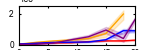

In [106]:
import seaborn as sns
select = merged[merged['day']<22]
width = 1.5
height = 0.5
fig,ax = plt.subplots(figsize=(width,height))
sns.lineplot(select,x="3day",y="spore_volume_x",hue = "treatment",ax=ax, palette=color_map,legend=False)

ax.set_xlabel('days after crossing')
ax.set_ylabel('$\Omega_{spore}$ \n($\mu m^3$)')
ax.set_xlim(0,20)
ax.set_ylim(0,2.5e8)
plt.savefig(os.path.join(path_figure,'Figure_rebutal_spore.pdf'), transparent=True, bbox_inches='tight')

2024-01-31 17:49:56,941-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


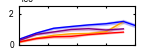

In [107]:
fig,ax = plt.subplots(figsize=(width,height))

sns.lineplot(select,x="3day",y="total_biovolume_estimated",hue = "treatment",ax=ax, palette=color_map,legend=False)
ax.set_xlabel('')
# ax.set_xlabel('days after crossing')
ax.set_xticklabels([])

ax.set_ylabel('$\Omega_{hyphae}$ \n ($\mu m^3$)')
ax.set_xlim(0,20)
ax.set_ylim(0,2.5e8)
plt.savefig(os.path.join(path_figure,'Figure_rebutal_length.pdf'), transparent=True, bbox_inches='tight')

In [92]:
data_harvest = pd.read_csv("2022_CarbonExperiment.csv",sep=";")

In [93]:
data_harvest['treatment'] = data_harvest['treatment']+data_harvest['fungus']


2024-01-31 10:53:29,366-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


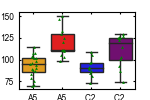

In [100]:
colors = {
    '100CA5': 'orange',
    '200CA5': 'red',
    '100CC2': 'blue',
    '200CC2': 'purple'
}
treatment_order = list(colors.keys())
select=data_harvest[data_harvest['treatment'].isin(colors.keys())]

width = 1.5
height = 1
fig,ax = plt.subplots(figsize=(width,height))
sns.boxplot(x='treatment', y = "dry root [mg]",data=select, ax=ax, color='white', fliersize=0,palette = colors, order=treatment_order)
# Add the individual points
sns.stripplot(x='treatment', y = "dry root [mg]", data=select, ax=ax, color='green', marker='^',size = 2, order=treatment_order)
# ax.set_yscale("log")
ax.set_ylabel("root dry weigth \n ($mg$)")
ax.set_xticklabels(['A5 \n 100C', 'A5 \n 200C','C2 \n 100C', 'C2 \n 200C'])

# Remove x-label
ax.set_xlabel('')
plt.savefig(os.path.join(path_figure,'FigureS4_root_weight.pdf'), transparent=True, bbox_inches='tight')

In [8]:
all_analysis_folders = get_analysis_folders()
plates = [
"822_20231204",
# "866_20231204",
"918_20231110"
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
time_plate_info = time_plate_info.replace(-1.0,np.nan)
width = 1.6
height = 1
# folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,use_saved=False)
# folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,use_saved=False)